In [1]:
from scipy.io.wavfile import read, write
import torchaudio
import torch
from librosa.util import normalize
from librosa.filters import mel as librosa_mel_fn
import numpy as np
import librosa
import librosa.display
from tqdm import tqdm
import os
import soundfile as sf
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
MAX_WAV_VALUE = 32768.0

def load_wav(full_path):
    sampling_rate, data = read(full_path)
    return data, sampling_rate

def dynamic_range_compression(x, C=1, clip_val=1e-5):
    return np.log(np.clip(x, a_min=clip_val, a_max=None) * C)

def dynamic_range_decompression(x, C=1):
    return np.exp(x) / C

def dynamic_range_compression_torch(x, C=1, clip_val=1e-5):
    return torch.log(torch.clamp(x, min=clip_val) * C)

def dynamic_range_decompression_torch(x, C=1):
    return torch.exp(x) / C

def spectral_normalize_torch(magnitudes):
    output = dynamic_range_compression_torch(magnitudes)
    return output

def spectral_de_normalize_torch(magnitudes):
    output = dynamic_range_decompression_torch(magnitudes)
    return output

mel_basis = {}
hann_window = {}

def mel_spectrogram(y, n_fft, num_mels, sampling_rate, hop_size, win_size, fmin, fmax, center=False):
    if torch.min(y) < -1.:
        print('min value is ', torch.min(y))
    if torch.max(y) > 1.:
        print('max value is ', torch.max(y))

    global mel_basis, hann_window
    if fmax not in mel_basis:
        mel = librosa_mel_fn(sr=sampling_rate, n_fft=n_fft, n_mels=num_mels, fmin=fmin, fmax=fmax)
        mel_basis[str(fmax)+'_'+str(y.device)] = torch.from_numpy(mel).float().to(y.device)
        hann_window[str(y.device)] = torch.hann_window(win_size).to(y.device)

    y = torch.nn.functional.pad(y.unsqueeze(1), (int((n_fft-hop_size)/2), int((n_fft-hop_size)/2)), mode='reflect')
    y = y.squeeze(1)

    spec = torch.stft(y, n_fft, hop_length=hop_size, win_length=win_size, window=hann_window[str(y.device)],
                      center=center, pad_mode='reflect', normalized=False, onesided=True)

    spec = torch.sqrt(spec.pow(2).sum(-1)+(1e-9))

    spec = torch.matmul(mel_basis[str(fmax)+'_'+str(y.device)], spec)
    spec = spectral_normalize_torch(spec)

    return spec

In [5]:
from IPython.display import Audio
import pandas as pd

In [17]:
fsd50k_root_data = []
with open("/home/v-yuancwang/AudioEditing/metadatas/fsd50k_short.txt","r") as f:
    lines = f.readlines()
for line in lines:
    fsd50k_root_data.append({"file_name": line.split("   ")[0], "text": line.split("   ")[1].replace("\n", "")})
print(len(fsd50k_root_data))
esc50_root_data = []
esc50_df = pd.read_csv("/home/v-yuancwang/AudioEditing/metadatas/esc50.csv")
esc50_df =  esc50_df[["filename", "category"]].to_numpy().tolist()
for file_name, text in esc50_df:
    esc50_root_data.append({"file_name": file_name, "text": text})
print(len(esc50_root_data))

21678
2000


In [10]:
fsd50k_path = "/blob/v-yuancwang/audio_editing_data/fsd50k"
esc50_path = "/blob/v-yuancwang/audio_editing_data/esc50"

In [19]:
file_name, text = fsd50k_root_data[16]['file_name'], fsd50k_root_data[16]['text']
print(file_name, text)
y1, sr = librosa.load(os.path.join(fsd50k_path, "wav", file_name))
spec1 = np.load(os.path.join(fsd50k_path, "mel", file_name.replace(".wav", ".npy")))
Audio(y1, rate=sr)

58874.wav Tambourine


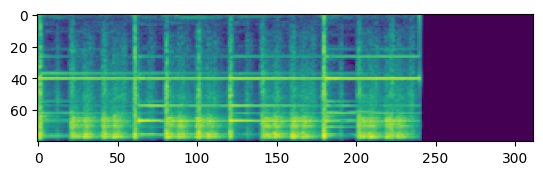

In [20]:
plt.imshow(spec1)

In [21]:
audioset_root_data = []
audioset96_path = "/blob/v-yuancwang/audio_editing_data/audioset96"

with open("/home/v-yuancwang/AudioEditing/metadatas/audioset96_file_label.txt","r") as f:
    lines = f.readlines()
for line in lines:
    audioset_root_data.append({"file_name": line.split("   ")[0], "text": line.split("   ")[1].replace("\n", "")})
print(len(audioset_root_data))

185925


In [ ]:
for i in range(100):
    id1 = np.random.randint(0, len(audioset_root_data))
    file_name1, text1 = audioset_root_data[id1]['file_name'], audioset_root_data[id1]['text']
    print(file_name1, text1)
    id2 = np.random.randint(0, len(fsd50k_root_data) + len(esc50_root_data))
    if id2 >= len(fsd50k_root_data):
        file_name2, text2 = esc50_root_data[id2%len(fsd50k_root_data)]['file_name'], esc50_root_data[id2%len(fsd50k_root_data)]['text']
    else:
        file_name2, text2 = fsd50k_root_data[id2]['file_name'], fsd50k_root_data[id2]['text']
    print(file_name2, text2)